# Real-time Sentiment Analysis and Trend Detection in Social Media Data using Machine Learning and Natural Language Processing.

#### Importing necessary libraries and setting up constants

In [1]:
from apify_client import ApifyClient
import requests
import pandas as pd
import time

MAX_RETRIES = 10  # Adjust as necessary
SLEEP_INTERVAL = 120  # 120 seconds, adjust as necessary

API_TOKEN = "apify_api_n0Nir3H5vg8WpscPwRIg69fk7374Zn3iGRLh"
ACTOR_URL = f"https://api.apify.com/v2/acts/quacker~twitter-scraper/runs?token={API_TOKEN}"

#### Defining functions for actor control and data collection

In [2]:
def start_actor():
    """
    Start the actor.
    """
    data = {
        "addUserInfo": True,
        "handles": ["BBCNews", "TelegraphNews", "GuardianNews", "SkyNews", "ReutersWorld", "CNN"],
        "proxyConfig": {"useApifyProxy": True},
        "tweetsDesired": 100
    }
    
    details = fetch_run_details()
    
    if details.get('data', {}).get('status') == "RUNNING":
        print("Last run is still active. Not starting a new actor job.")
    else:
        response = requests.post(ACTOR_URL, json=data)
        if response.status_code == 201:
            print("Actor started successfully!")
        else:
            print(f"Failed to start the actor. Error: {response.text}")

def fetch_run_details():
    """
    Fetch the details of the last run of the actor.
    """
    details_url = f"https://api.apify.com/v2/acts/quacker~twitter-scraper/runs/last?token={API_TOKEN}"
    return requests.get(details_url).json()

def fetch_dataset():
    """
    Fetch the dataset items from the last run.
    """
    dataset_url = f"https://api.apify.com/v2/acts/quacker~twitter-scraper/runs/last/dataset/items?token={API_TOKEN}"
    return requests.get(dataset_url).json()

def data_collection():
    """
    Handles the data collection process.
    
    Returns:
        DataFrame: Returns a pandas DataFrame with the fetched data or None.
    """
    client = ApifyClient(token=API_TOKEN)

    retries = 0
    while retries < MAX_RETRIES:
        details = fetch_run_details()

        if details.get('data', {}).get('status') == "SUCCEEDED":
            data = fetch_dataset()
            df = pd.DataFrame(data)
            print(df.head())
            return df

        elif details.get('data', {}).get('status') == "ERROR":
            print("Actor job errored out. Stopping data collection.")
            return None

        else:
            print(f"Job still running... Waiting for {SLEEP_INTERVAL} seconds before checking again.")
            time.sleep(SLEEP_INTERVAL)
            retries += 1

    print("Max retries reached. Job might still be running or there might be another issue.")
    return None

#### Starting the actor and collecting data

In [3]:
start_actor()
data = data_collection()
print(data.head())

Actor started successfully!
Job still running... Waiting for 120 seconds before checking again.
                                                user                   id  \
0  {'created_at': '2007-02-09T00:35:02.000Z', 'de...  1325112684644347904   
1  {'created_at': '2007-02-09T00:35:02.000Z', 'de...   866570583114489856   
2  {'created_at': '2007-02-09T00:35:02.000Z', 'de...  1176159504288886785   
3  {'created_at': '2007-02-09T00:35:02.000Z', 'de...  1565436402707435522   
4  {'created_at': '2007-02-09T00:35:02.000Z', 'de...  1266315061221613569   

       conversation_id                                          full_text  \
0  1325112684644347904  BREAKING: JOE BIDEN WINS\n\nJoe Biden will be ...   
1   866570583114489856  Bigger than Bieber? A Korean pop group beats U...   
2  1176159504288886785  "You have stolen my dreams and my childhood wi...   
3  1565436402707435522                                      breaking news   
4  1266315061221613569  Minnesota police arrest CNN repo

#### Natural Language Processing (NLP) and Text Processing

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download required datasets if not already downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize stopwords and lemmatizer outside the function
STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()

def preprocess_text(text):
    # Noise Removal
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\S+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove numbers and punctuations
    text = re.sub(r'\bRT\b', '', text)  # Remove RT (retweet indicators)
    
    # Text Normalization
    text = text.lower()  # Convert to lowercase
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Stopword Removal
    tokens = [token for token in tokens if token not in STOP_WORDS]
    
    # Lemmatization
    tokens = [LEMMATIZER.lemmatize(token) for token in tokens]
    
    # Convert tokens back to string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Process each text in the dataset
processed_texts = [preprocess_text(text) for text in data['full_text']]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tejeshraorb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tejeshraorb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tejeshraorb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Generating Word Cloud

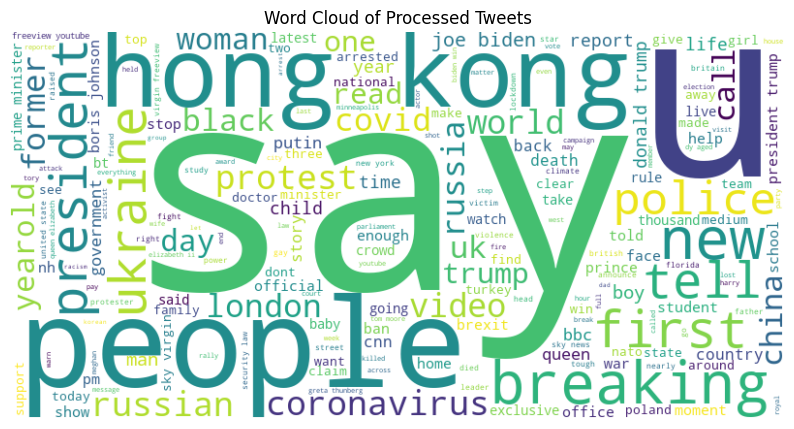

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Concatenate all processed texts
all_words = ' '.join(processed_texts)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Tweets")
plt.show()

#### Analyzing Word Frequencies

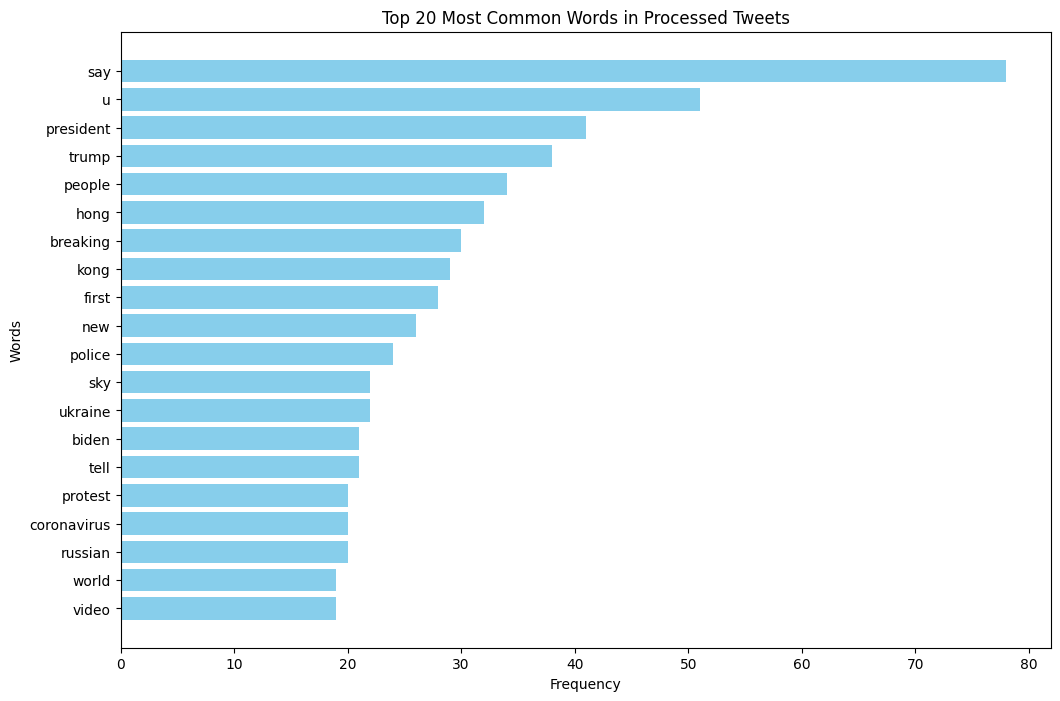

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# Tokenize the processed_texts
all_tokens = [word for text in processed_texts for word in text.split()]

# Count the frequency of each word
word_freq = Counter(all_tokens)

# Get the top 20 most common words
top_words = word_freq.most_common(20)

# Unzip the word-frequency pairs into two lists
words, frequencies = zip(*top_words)

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Processed Tweets")
plt.gca().invert_yaxis()  # To display the word with the highest frequency at the top
plt.show()

#### Feature Extraction (BoW and TF-IDF)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words (BoW) transformation
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(processed_texts)

# TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(processed_texts)

#### Visualizing Text Data with t-SNE

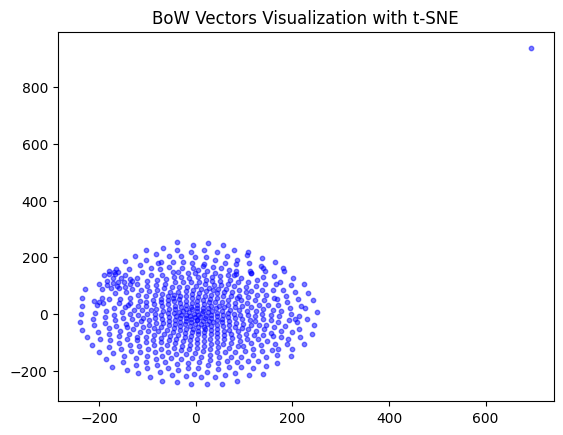

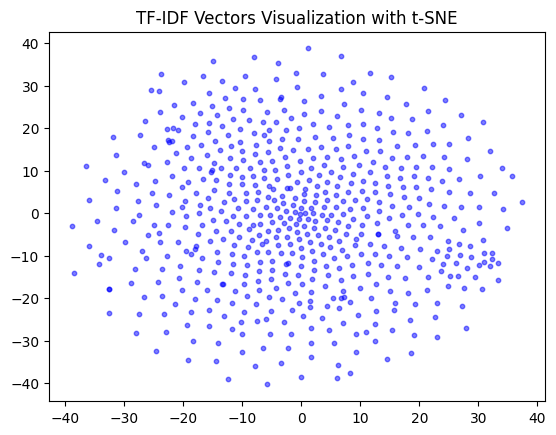

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_vectors(X, title):
    tsne = TSNE(n_components=2, random_state=0)
    reduced = tsne.fit_transform(X.toarray())  # Convert sparse matrix to dense

    plt.scatter(reduced[:, 0], reduced[:, 1], s=10, c='b', alpha=0.5)
    plt.title(title)
    plt.show()

# Visualizing BoW vectors
visualize_vectors(X_bow, "BoW Vectors Visualization with t-SNE")

# Visualizing TF-IDF vectors
visualize_vectors(X_tfidf, "TF-IDF Vectors Visualization with t-SNE")

#### Part-of-Speech Tagging and Visualization

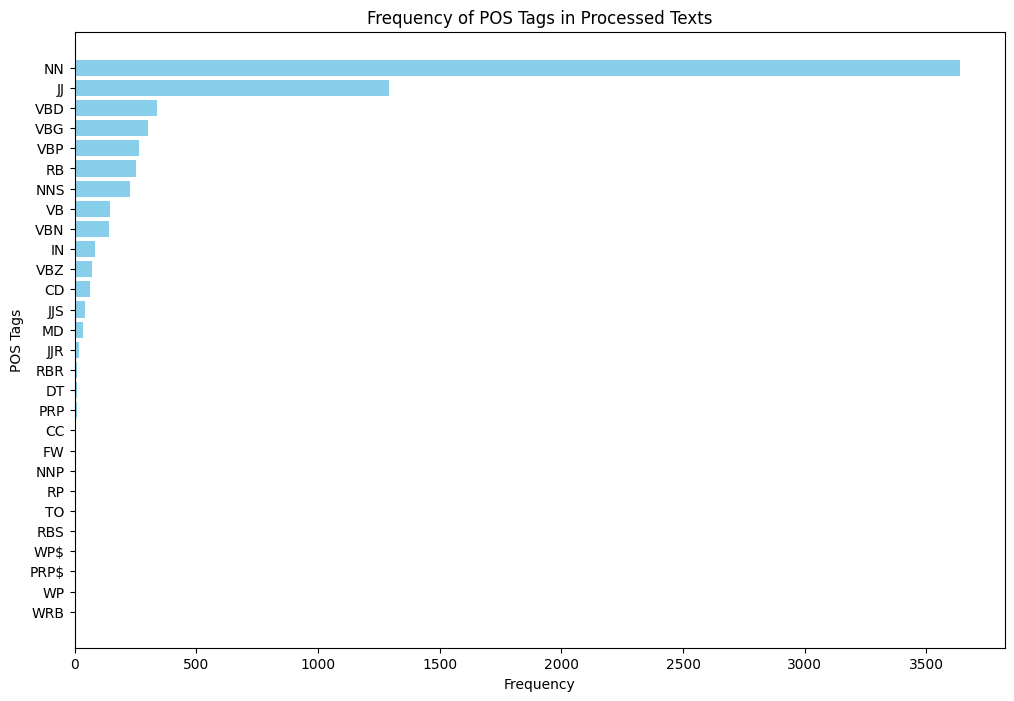

In [9]:
import nltk

def pos_tags(text):
    """Extracts and returns the part-of-speech tags from the given text."""
    return ' '.join([tag for word, tag in nltk.pos_tag(word_tokenize(text))])

# Apply the pos_tags function to each processed text
processed_texts_pos = [pos_tags(text) for text in processed_texts]

from collections import Counter
import matplotlib.pyplot as plt

def visualize_pos(tags_list):
    all_tags = ' '.join(tags_list).split()
    tag_freq = Counter(all_tags)

    tags, frequencies = zip(*tag_freq.most_common())
    
    plt.figure(figsize=(12, 8))
    plt.barh(tags, frequencies, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("POS Tags")
    plt.title("Frequency of POS Tags in Processed Texts")
    plt.gca().invert_yaxis()
    plt.show()

visualize_pos(processed_texts_pos)

#### Word2Vec Embeddings and Visualization

Number of unique words in the model's vocabulary: 3124


[('embassy', 0.3516392707824707), ('demonstrator', 0.3398902714252472), ('wait', 0.3113839030265808), ('woe', 0.3081211447715759), ('bunker', 0.2935427725315094)]


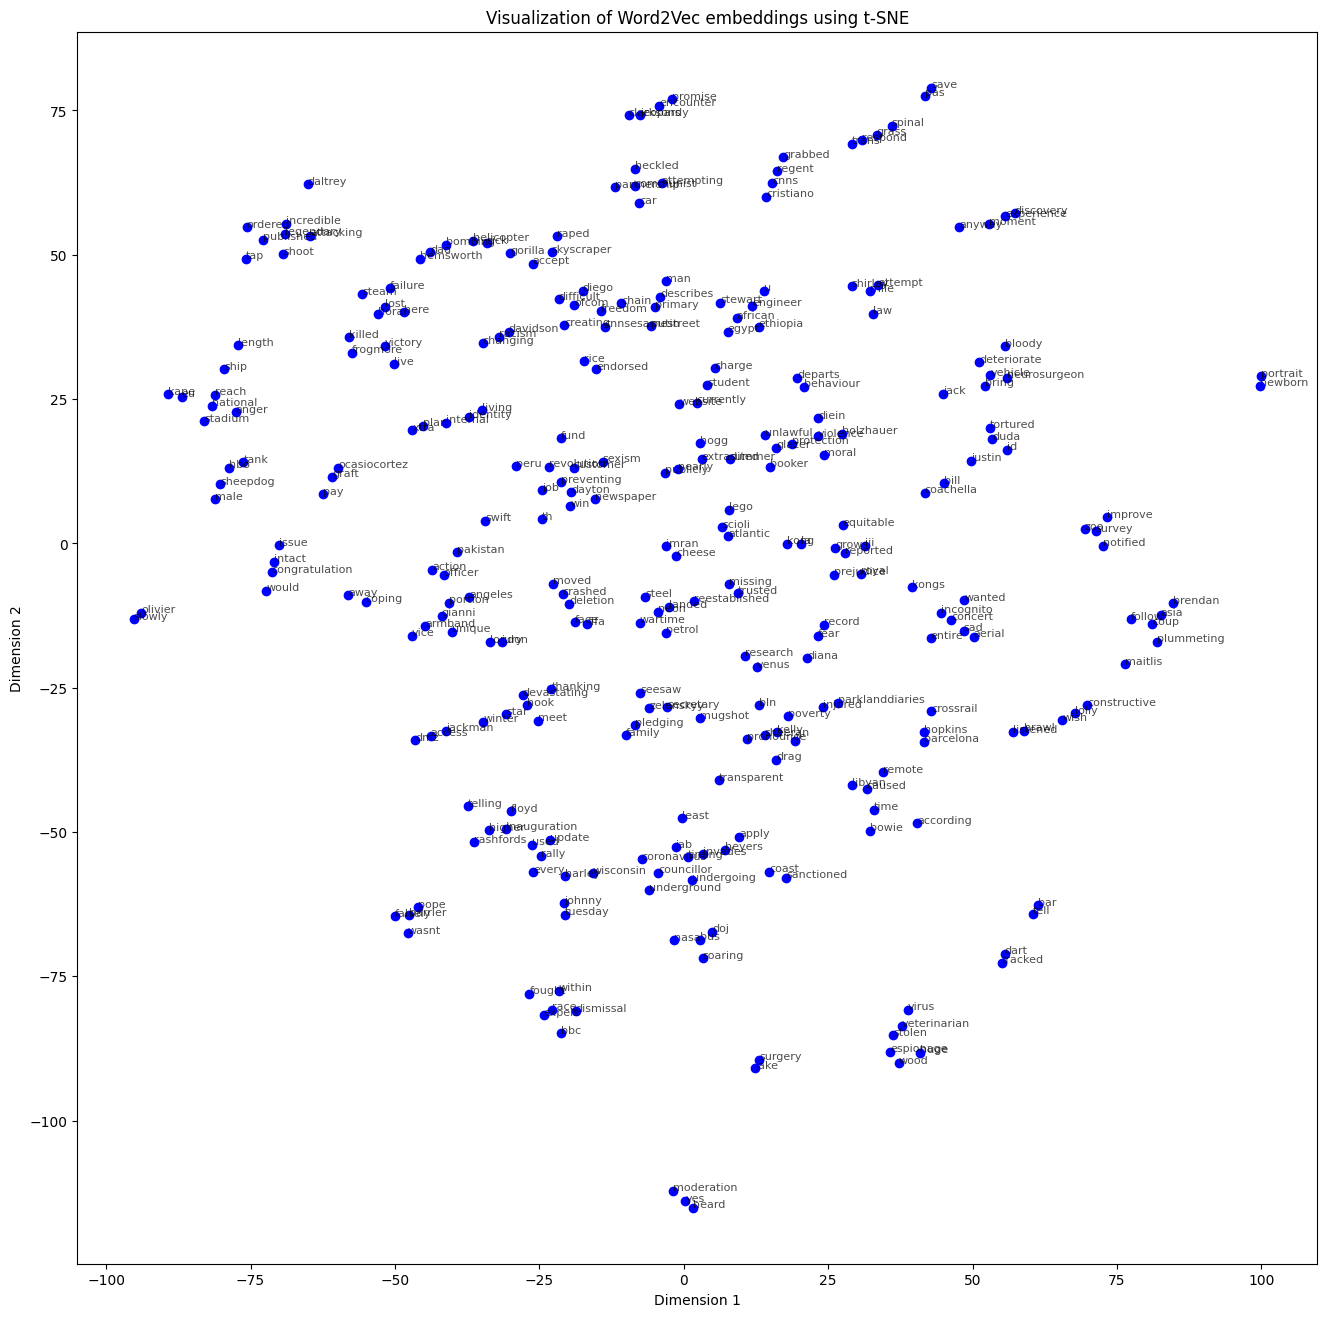

In [10]:
from gensim.models import Word2Vec

# Tokenizing the processed texts
tokens = [word_tokenize(text) for text in processed_texts]

# Training Word2Vec model
model_w2v = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
model_w2v.save("word2vec.model")

print(f"Number of unique words in the model's vocabulary: {len(model_w2v.wv.index_to_key)}" + '\n\n')

# Display most similar words to the word "example"
print(model_w2v.wv.most_similar("covid", topn=5))

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def visualize_word2vec(model, words=None, sample_size=300):
    """Visualize Word2Vec embeddings using t-SNE."""
    
    # If no word list is given, randomly sample from the model's vocabulary
    if not words:
        words = list(model.wv.index_to_key)
        words = [words[i] for i in np.random.choice(len(words), sample_size, replace=False)]
    
    word_vectors = [model.wv[word] for word in words]
    
    # Convert word_vectors to a NumPy array
    word_vectors = np.array(word_vectors)
    
    tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
    tsne_values = tsne.fit_transform(word_vectors)
    
    plt.figure(figsize=(16, 16))
    for i in range(len(tsne_values)):
        plt.scatter(tsne_values[i][0], tsne_values[i][1], color='blue')
        plt.annotate(words[i], (tsne_values[i][0], tsne_values[i][1]), fontsize=8, alpha=0.7)
    
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Visualization of Word2Vec embeddings using t-SNE")
    plt.show()

# Visualize a random subset of 300 words from the trained model's vocabulary
visualize_word2vec(model_w2v)

#### Sentiment Analysis

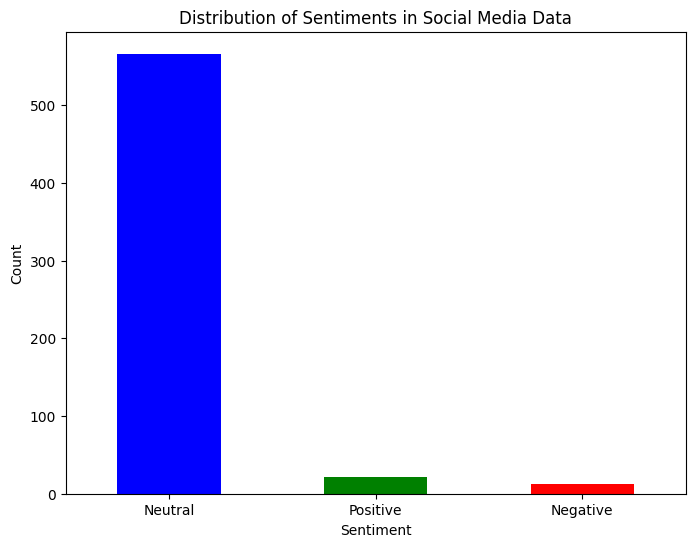

In [11]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd

# Function to perform sentiment analysis
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity < -0.5:
        return "Negative"
    elif polarity > 0.5:
        return "Positive"
    else:
        return "Neutral"

# Apply sentiment analysis to each processed text
sentiments_categorical = [get_sentiment(text) for text in processed_texts]

# Create a DataFrame to analyze sentiment distribution
sentiments_df = pd.DataFrame(sentiments_categorical, columns=["Sentiment"])
sentiment_counts = sentiments_df["Sentiment"].value_counts()

# Define colors for each sentiment category
colors = {
    "Negative": "red",
    "Positive": "green",
    "Neutral": "blue"
}

# Plot the sentiment distribution with custom colors
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=[colors[sent] for sent in sentiment_counts.index])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiments in Social Media Data")
plt.xticks(rotation=0)
plt.show()

#### N-grams Feature Extraction

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer with n-gram range (1, 3)
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))

# Fit and transform the processed texts to generate n-gram features
X_ngrams = ngram_vectorizer.fit_transform(processed_texts)

#### Dimensionality Reduction (PCA)

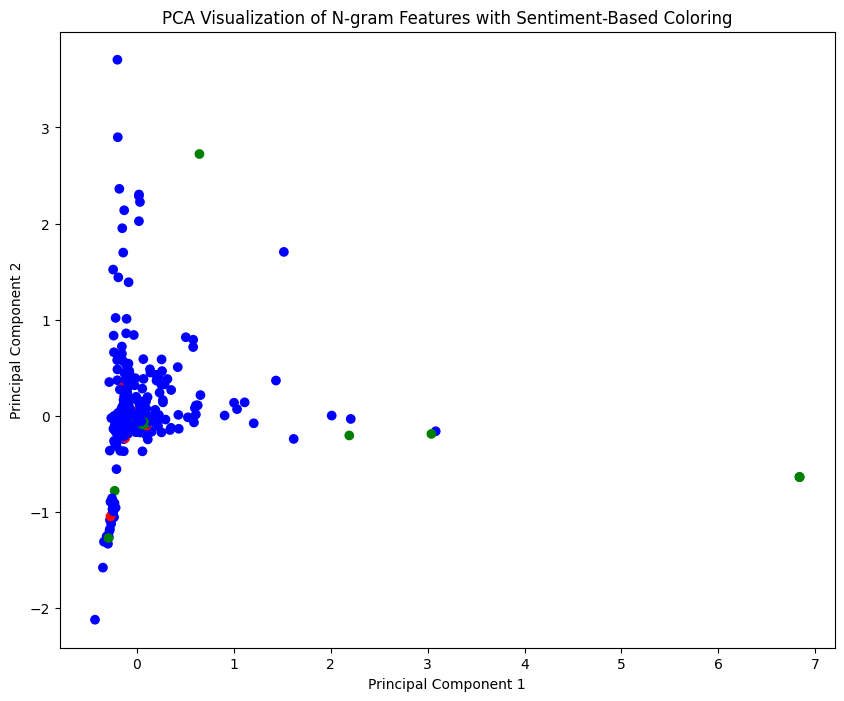

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define a color map for sentiment labels
sentiment_colors = {
    "Neutral": "blue",
    "Positive": "green",
    "Negative": "red"
}

# Map sentiment labels to colors
sentiment_colors_mapped = [sentiment_colors[sentiment] for sentiment in sentiments_categorical]

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_ngrams.toarray())

# Visualize the PCA-transformed data with sentiment-based coloring
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=sentiment_colors_mapped)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of N-gram Features with Sentiment-Based Coloring")
plt.show()

#### Text Classification with Machine Learning

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow, sentiments_categorical, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Support Vector Machine
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_pred_svc))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
     Neutral       0.92      1.00      0.96       110
    Positive       1.00      0.12      0.22         8

    accuracy                           0.93       120
   macro avg       0.64      0.38      0.39       120
weighted avg       0.91      0.93      0.90       120

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
     Neutral       0.92      1.00      0.96       110
    Positive       1.00      0.12      0.22         8

    accuracy                           0.93       120
   macro avg       0.64      0.38      0.39       120
weighted avg       0.91      0.93      0.90       120

Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
   

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metr

#### Text Classification with BERT

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(processed_texts)
sequences = tokenizer.texts_to_sequences(processed_texts)
padded = pad_sequences(sequences, padding='post')

# Encode sentiment labels
label_encoder = LabelEncoder()
sentiments_encoded = label_encoder.fit_transform(sentiments_categorical)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64, input_length=len(padded[0])),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model on the data
model.fit(padded, sentiments_encoded, epochs=10, validation_split=0.2)

Epoch 1/10
15/15 [==============================] - 0s 9ms/step - loss: 0.4818 - accuracy: 0.9354 - val_loss: 0.1724 - val_accuracy: 0.9500
Epoch 2/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0569 - accuracy: 0.9417 - val_loss: -0.1598 - val_accuracy: 0.9500
Epoch 3/10
15/15 [==============================] - 0s 5ms/step - loss: -0.0786 - accuracy: 0.9417 - val_loss: -0.2707 - val_accuracy: 0.9500
Epoch 4/10
15/15 [==============================] - 0s 5ms/step - loss: -0.1232 - accuracy: 0.9417 - val_loss: -0.3739 - val_accuracy: 0.9500
Epoch 5/10
15/15 [==============================] - 0s 5ms/step - loss: -0.1808 - accuracy: 0.9417 - val_loss: -0.5164 - val_accuracy: 0.9500
Epoch 6/10
15/15 [==============================] - 0s 5ms/step - loss: -0.2643 - accuracy: 0.9417 - val_loss: -0.6347 - val_accuracy: 0.9500
Epoch 7/10
15/15 [==============================] - 0s 5ms/step - loss: -0.3846 - accuracy: 0.9417 - val_loss: -0.8730 - val_accuracy: 0.9500
Epoch 8/1

#### K-Means Clustering

In [16]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3).fit(X_bow)
data['cluster'] = kmeans.labels_

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Latent Dirichlet Allocation (LDA)

In [17]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Create an instance of LDA with the desired number of topics (e.g., 5)
lda = LDA(n_components=5)
lda.fit(X_bow)  # Fit LDA to your bag-of-words data (X_bow)

# Function to print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Call the function to print the top words for each topic
print_top_words(lda, vectorizer.get_feature_names_out(), 10)


Topic #0:
president trump say biden state joe breaking office new cnn

Topic #1:
say president trump prince sky queen youtube minister country new

Topic #2:
hong kong protest police first china london security law day

Topic #3:
say uk people putin russian boy former russia woman going

Topic #4:
say breaking people news video coronavirus sky first london like


#### Visualization of LDA Topics

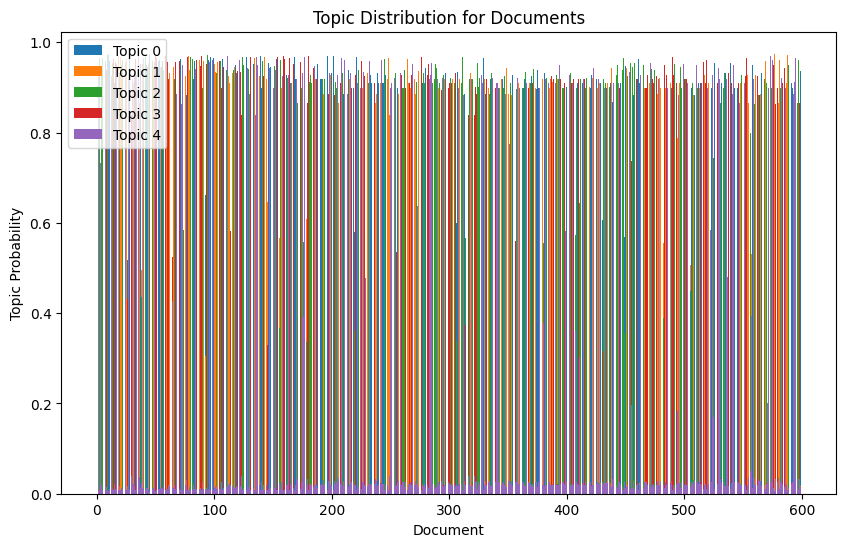

In [18]:
import matplotlib.pyplot as plt

# Get the topic distribution for each document
topic_distribution = lda.transform(X_bow)

# Create a bar plot to visualize the distribution of topics
plt.figure(figsize=(10, 6))
for i in range(topic_distribution.shape[1]):
    plt.bar(range(len(topic_distribution)), topic_distribution[:, i], label=f"Topic {i}")
plt.xlabel("Document")
plt.ylabel("Topic Probability")
plt.title("Topic Distribution for Documents")
plt.legend()
plt.show()

### BERT Text Classification

In [19]:
from transformers import InputExample, InputFeatures, BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

# Define your training sentences and labels
train_sentences = ["Hello world!", "Machine learning is fun.", "BERT is powerful."]
train_labels = [0, 1, 1]  # Assuming two classes: 0 and 1

# Create InputExample objects from your sentences and labels
input_examples = [InputExample(guid="", text_a=sentence, text_b=None, label=label) for sentence, label in zip(train_sentences, train_labels)]

# Function to convert InputExamples to a TensorFlow dataset
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict["attention_mask"])
        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

# Convert InputExamples to a TensorFlow dataset
train_dataset = convert_examples_to_tf_dataset(input_examples, tokenizer).shuffle(100).batch(32)

# Compile and train the BERT model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=2)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1/1 [==============================] - 8s 8s/step - loss: 0.6931 - accuracy: 0.6667
Epoch 2/2
1/1 [==============================] - 1s 973ms/step - loss: 0.6931 - accuracy: 0.6667


#### Model Evaluation: Cross-validation of BERT model 

In [20]:
from transformers import InputExample, InputFeatures, BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

# Define your actual training sentences and labels
train_sentences = ["Sentence 1", "Sentence 2", "Sentence 3", "Sentence 4", "Sentence 5", "Sentence 6"]
train_labels = [0, 1, 1, 0, 1, 0]  # Assuming two classes: 0 and 1

# Create InputExample objects from your sentences and labels
input_examples = [InputExample(guid="", text_a=sentence, text_b=None, label=label) for sentence, label in zip(train_sentences, train_labels)]

# Function to convert InputExamples to a TensorFlow dataset
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict["attention_mask"])
        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

# Perform stratified k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
accuracy_scores = []

for train_indices, val_indices in kfold.split(train_sentences, train_labels):
    # Split the dataset into train and validation sets
    train_set = [input_examples[i] for i in train_indices]
    val_set = [input_examples[i] for i in val_indices]
    
    # Convert InputExamples to TensorFlow datasets
    train_dataset = convert_examples_to_tf_dataset(train_set, tokenizer).shuffle(100).batch(32)
    val_dataset = convert_examples_to_tf_dataset(val_set, tokenizer).batch(32)
    
    # Compile and train the BERT model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_dataset, epochs=2, verbose=0)  # Training for simplicity
    
    # Evaluate the model on the validation set
    val_results = model.evaluate(val_dataset)
    accuracy_scores.append(val_results[1])  # Accuracy is at index 1

# Calculate and print the average accuracy across folds
average_accuracy = np.mean(accuracy_scores)
print(f"Average Accuracy Across Folds: {average_accuracy:.2%}")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 [==============================] - 2s 2s/step - loss: 0.6931 - accuracy: 0.5000
Average Accuracy Across Folds: 50.00%
